# Previsão do preço de ações

Autor do notebook: [Bruno Silva](https://github.com/bgsilva)

Notebook criado para ilustrar como podemos usar o Python e algumas de suas principais bibliotecas para criar modelos de previsão do preço de ações.

Como métricas de avaliação dos modelos, serão utilizadas: RMSE, MAE e MAPE.

Última atualização: Jan/2022.

## Importando as bibliotecas

Abaixo importamos as bibliotecas que serão utizadas no código a seguir.

In [1]:
# importando as bibliotecas utilizadas
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

Também foram criadas duas funções que serão utilizadas mais a frente.

In [37]:
# Função criada para plotar gráficos interativos usando o Plotly Express
def interactive_plot(df, title, width=800, height=600):
    fig = px.line(title=title, width=width, height=height)
    for i in df.columns[1:]:
        fig.add_scatter(x=df['Date'], y=df[i], name=i)
    fig.show()

# Função criada para a utilização métrica MAPE
def mape(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

## Carregando o dados

A ação utilizada nos modelos criados será a ação `MGLU3`, mas poderia ser qualquer outra.

Para obter os dados, usaremos a biblioteca `yfinance`.

O período analisado será de 4/1/2016 até 5/1/2022.

In [48]:
today = datetime.today().strftime('2022-01-06')
start_date = '2016-01-01'
mglu3_df = yf.download('MGLU3.SA',start_date, today)
mglu3_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,0.066210,0.071484,0.064921,0.070117,0.066922,138547200
2016-01-05,0.071523,0.072578,0.070117,0.070820,0.067593,96179200
2016-01-06,0.070820,0.071484,0.064687,0.064687,0.061740,117324800
2016-01-07,0.062500,0.062500,0.051171,0.056093,0.053537,226688000
2016-01-08,0.058593,0.059570,0.055664,0.056328,0.053762,97638400
...,...,...,...,...,...,...
2021-12-29,6.840000,6.900000,6.700000,6.760000,6.760000,79247400
2021-12-30,6.800000,7.410000,6.770000,7.220000,7.220000,180329400
2022-01-03,7.410000,7.410000,6.670000,6.720000,6.720000,145442000


Precisamos deixar 'Date' como coluna:

In [49]:
# ajustando 'Date' como coluna
mglu3_df = mglu3_df.reset_index() 

Aqui podemos observar algumas infomações básicas do dataset e suas features.

In [50]:
mglu3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1495 non-null   datetime64[ns]
 1   Open       1495 non-null   float64       
 2   High       1495 non-null   float64       
 3   Low        1495 non-null   float64       
 4   Close      1495 non-null   float64       
 5   Adj Close  1495 non-null   float64       
 6   Volume     1495 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 81.9 KB


Abaixo temos um resumo estatístico das features numéricas.

In [51]:
mglu3_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1.495000e+03
mean,8.245743,8.408608,8.065304,8.232730,8.142536,4.556399e+07
std,8.189070,8.336370,8.023556,8.176630,8.175397,3.128634e+07
min,0.049687,0.051484,0.049218,0.049453,0.047200,0.000000e+00
25%,1.037050,1.080078,1.025801,1.079102,1.034964,2.649600e+07
50%,5.250000,5.318750,5.140937,5.233750,5.079213,3.795480e+07
75%,13.867500,14.177500,13.535000,13.880000,13.674764,5.468160e+07
max,28.150000,28.309999,26.740000,27.450001,27.401571,3.612832e+08


Aqui temos uma visão da cotação da ação de 2016 até o início de 2022:

<AxesSubplot:xlabel='Date'>

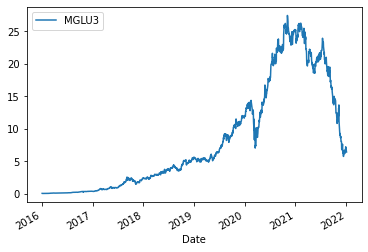

In [52]:
# Gráfico do preço de fechamento ajustado ('Adj Close') de MGLU3
mglu3_df.plot(x='Date', y='Adj Close', label='MGLU3', legend=True)

## Modelo *baseline*

Para a modelagem, serão utilizadas como features as colunas 'Date', 'Open', 'High', 'Low', 'Volume' e o como target a coluna 'Adj Close'.

In [53]:
mglu3_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [54]:
mglu3_df = mglu3_df[['Date', 'Open', 'High', 'Low', 'Volume', 'Adj Close']]
mglu3_df.head()

,Date,Open,High,Low,Volume,Adj Close
0,2016-01-04,0.066210,0.071484,0.064921,138547200,0.066922
1,2016-01-05,0.071523,0.072578,0.070117,96179200,0.067593
2,2016-01-06,0.070820,0.071484,0.064687,117324800,0.061740
3,2016-01-07,0.062500,0.062500,0.051171,226688000,0.053537
4,2016-01-08,0.058593,0.059570,0.055664,97638400,0.053762


Normalizando os dados com MinMaxScaler:

In [59]:
sc = MinMaxScaler(feature_range= (0,1))
scaled_df = sc.fit_transform(mglu3_df.drop(columns='Date'))
print(scaled_df.shape)
scaled_df

(1495, 5)


array([[0.000588  , 0.00070775, 0.00058833, 0.38348642, 0.000721  ],
       [0.00077707, 0.00074647, 0.000783  , 0.26621553, 0.00074553],
       [0.00075206, 0.00070775, 0.00057956, 0.32474469, 0.00053154],
       ...,
       [0.26192993, 0.26039994, 0.24805501, 0.40257061, 0.24393907],
       [0.23951026, 0.2437678 , 0.23981245, 0.22471928, 0.23735877],
       [0.23025769, 0.23633641, 0.23681516, 0.25649657, 0.23297191]])

Criando as variáveis para features e target e separando os dados para treino e teste.

In [60]:
# criando as features e o target
X = scaled_df[:, :4]
y = scaled_df[:, 4:]

# split the data in 70% training and 30% testing
split = int(0.7 * (len(X)))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

### Ridge Regression

In [61]:
model = Ridge()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'Ridge Regression score: {accuracy}')

Ridge Regression score: 0.9800673067834529


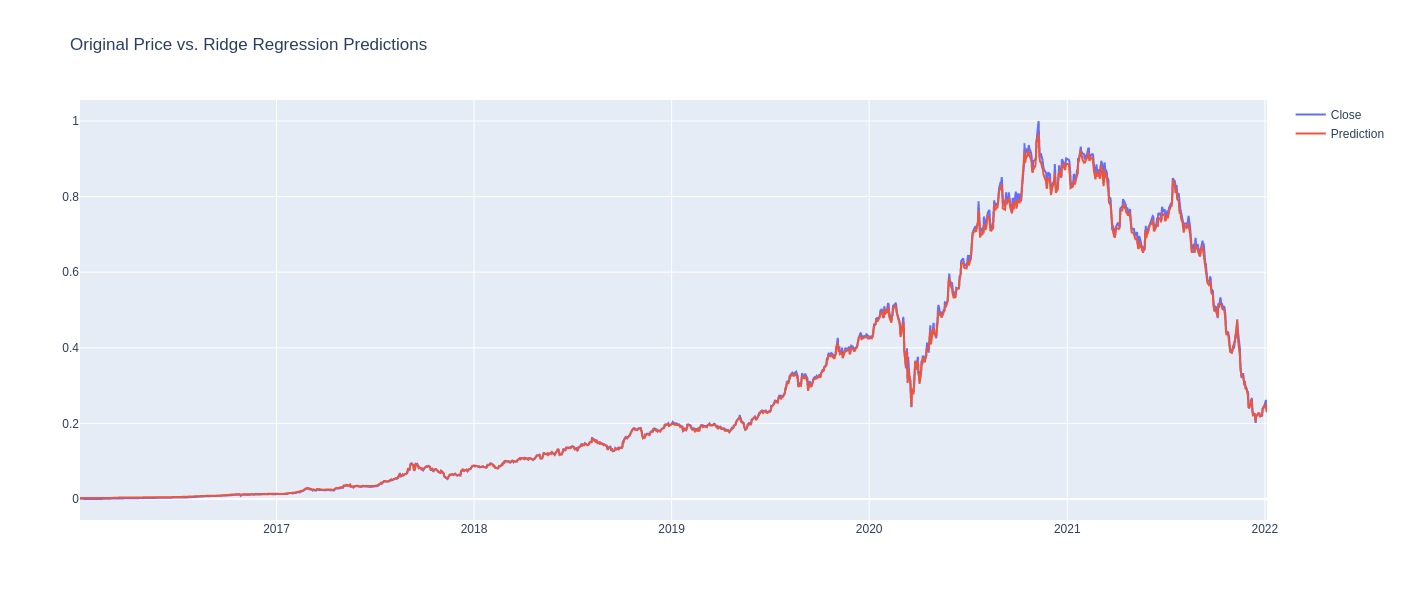

In [62]:
# Price predicting
predicted_price = model.predict(X)

# add the predicted values into a list
Predicted = []
for i in predicted_price:
    Predicted.append(i[0])

# Append the close values to the list
close = []
for i in scaled_df:
    close.append(i[0])

df_predicted = mglu3_df[['Date']]

df_predicted['Close'] = close

df_predicted['Prediction'] = Predicted

# plotting the data
interactive_plot(df_predicted, 'Original Price vs. Ridge Regression Predictions')

In [16]:
MAE = mean_absolute_error(y, predicted_price)
print(f'MAE: {MAE}')
MSE = mean_squared_error(y, predicted_price)
print(f'MSE: {MSE}')
MAPE = mape(y, predicted_price)
print(f"MAPE (%): {MAPE}")

MAE: 0.020293804935266013
MSE: 0.0009597212005537141
MAPE (%): inf


/tmp/ipykernel_37367/2680554901.py:9: RuntimeWarning:

divide by zero encountered in true_divide



### Testando o modelo com dados novos

Obtendo a ação a ser analisada: `MGLU3`

In [17]:
stock = pd.read_csv("mglu3_5y_up.csv")
stock = stock.reset_index()
stock

,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0,2017-01-06,0.370218,0.372306,0.365371,0.367832,6400000,0.0,0.0
1,1,2017-01-09,0.367869,0.369099,0.351092,0.351092,29849600,0.0,0.0
2,2,2017-01-10,0.352695,0.365371,0.352359,0.359443,19968000,0.0,0.0
3,3,2017-01-11,0.357802,0.366490,0.357802,0.363507,28748800,0.0,0.0
4,4,2017-01-12,0.368354,0.389568,0.367497,0.387741,41216000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1238,1238,2021-12-30,6.800000,7.410000,6.770000,7.220000,180329400,0.0,0.0
1239,1239,2022-01-03,7.410000,7.410000,6.670000,6.720000,145442000,0.0,0.0
1240,1240,2022-01-04,6.780000,6.940000,6.450000,6.540000,81187300,0.0,0.0
1241,1241,2022-01-05,6.520000,6.730000,6.370000,6.420000,92667900,0.0,0.0


In [18]:
stock = stock[['Date', 'Close', 'Volume']]
stock.head()

,Date,Close,Volume
0,2017-01-06,0.367832,6400000
1,2017-01-09,0.351092,29849600
2,2017-01-10,0.359443,19968000
3,2017-01-11,0.363507,28748800
4,2017-01-12,0.387741,41216000


In [19]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1243 non-null   object 
 1   Close   1243 non-null   float64
 2   Volume  1243 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.3+ KB


In [20]:
stock['Target'] = stock[['Close']].shift(-5)

In [21]:
stock = stock.dropna()
stock

,Date,Close,Volume,Target
0,2017-01-06,0.367832,6400000,0.395197
1,2017-01-09,0.351092,29849600,0.387405
2,2017-01-10,0.359443,19968000,0.395197
3,2017-01-11,0.363507,28748800,0.397248
4,2017-01-12,0.387741,41216000,0.400417
...,...,...,...,...
1233,2021-12-22,6.160000,85327900,7.220000
1234,2021-12-23,6.200000,97106100,6.720000
1235,2021-12-27,6.780000,124279800,6.540000
1236,2021-12-28,6.830000,165573900,6.420000


Normalizando os dados com MinMaxScaler

In [22]:
sc = MinMaxScaler(feature_range= (0,1))
scaled_df = sc.fit_transform(stock.drop(columns='Date'))
print(scaled_df.shape)
scaled_df

(1238, 3)


array([[6.18841693e-04, 1.77146349e-02, 2.88440008e-04],
       [0.00000000e+00, 8.26210574e-02, 0.00000000e+00],
       [3.08732265e-04, 5.52696610e-02, 2.88440008e-04],
       ...,
       [2.37663379e-01, 3.43995514e-01, 2.27754376e-01],
       [2.39511765e-01, 4.58293937e-01, 2.23312267e-01],
       [2.36924022e-01, 2.19349806e-01, 2.19980676e-01]])

In [23]:
# Create Feature and Target
X = scaled_df[:, :2]
y = scaled_df[:, 2:]

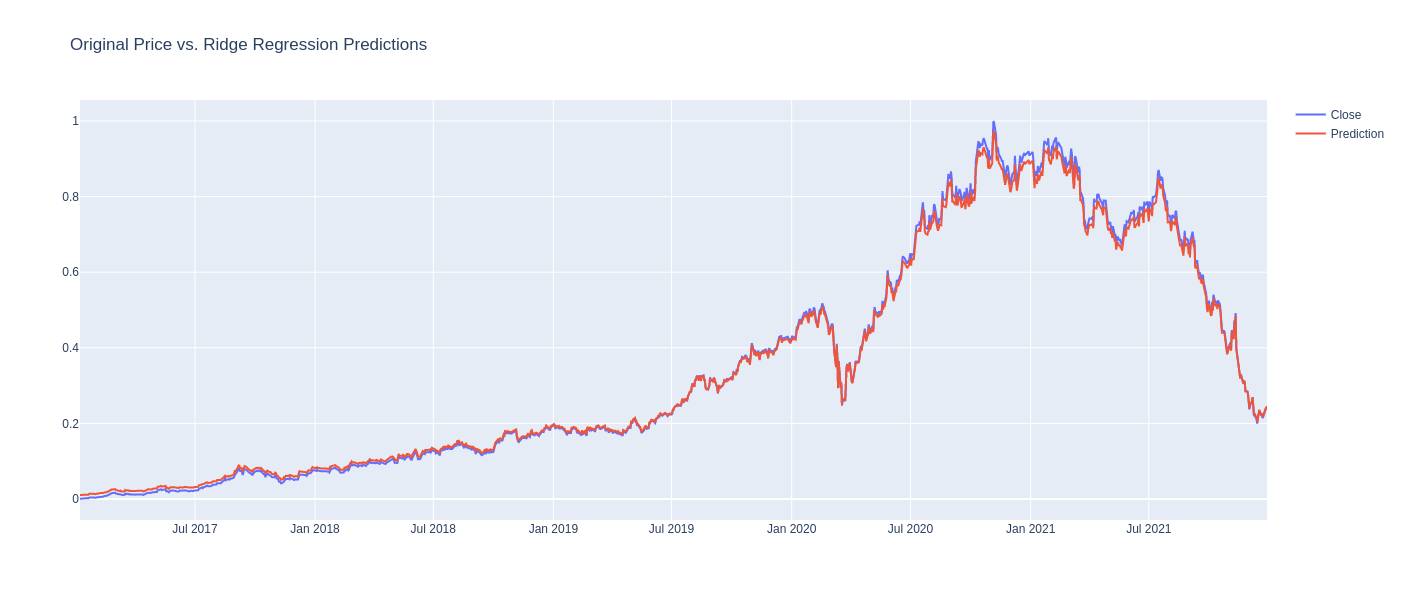

In [24]:
# Previsão de preço
predicted_price = model.predict(X)

# adicionando os valores previstos em uma lista
Predicted = []
for i in predicted_price:
    Predicted.append(i[0])

# adicionando os valores de fechamento ('Close') em uma lista
close = []
for i in scaled_df:
    close.append(i[0])

df_predicted = stock[['Date']]

df_predicted['Close'] = close

df_predicted['Prediction'] = Predicted

# Plotando os dados
interactive_plot(df_predicted, 'Original Price vs. Ridge Regression Predictions')

In [25]:
MAE = mean_absolute_error(y, predicted_price)
print(f'MAE: {MAE}')
MSE = mean_squared_error(y, predicted_price)
print(f'MSE: {MSE}')
MAPE = mape(y, predicted_price)
print(f"MAPE (%): {MAPE}")

MAE: 0.020620220755755345
MSE: 0.0009661482070241857
MAPE (%): inf


/tmp/ipykernel_37367/2680554901.py:9: RuntimeWarning:

divide by zero encountered in true_divide



## Sugestões para melhoramento dos modelos

* Criação de novas features
* Otimização de hiperparâmetros

## Referências

### Básicas

* [Prevendo valores de ações usando Machine Learning e Deep Learning](https://danilofelipeneto.medium.com/prevendo-valores-de-a%C3%A7%C3%B5es-usando-machine-learning-e-deep-learning-80216e55e582)
* [Predicting Stock Prices with Linear Regression in Python](https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/)

### Modelos mais avançados

* [Building a Stock Price Predictor Using Python](https://www.section.io/engineering-education/stock-price-prediction-using-python/)